In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

random_state = 44

In [86]:
df = pd.read_csv("features.csv", index_col=0)
df.dropna(inplace=True)
X = df.drop(columns=['malign', 'patient_name'])
y = df['malign']


In [87]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
scaler.transform(X)

array([[0.66872238, 0.32067174, 0.33801178, ..., 0.        , 0.        ,
        0.        ],
       [0.81503525, 0.43431311, 0.47255324, ..., 0.        , 0.        ,
        0.        ],
       [0.89418626, 0.43642804, 0.52003056, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.63515194, 0.17930703, 0.19413937, ..., 0.        , 0.        ,
        0.        ],
       [0.23890031, 0.14268305, 0.14697542, ..., 0.        , 0.        ,
        0.        ],
       [0.21205056, 0.08051066, 0.07892094, ..., 0.        , 0.        ,
        0.        ]])

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

In [89]:
tree = DecisionTreeClassifier(random_state=random_state, max_depth=100, min_samples_split=100, criterion='entropy')
ada = AdaBoostClassifier(random_state=random_state)
bagging = BaggingClassifier(random_state=random_state)
boost = GradientBoostingClassifier(random_state=random_state)
forest = RandomForestClassifier(random_state=random_state)

clfs = [tree, ada, bagging, boost, forest]
for clf in clfs:
    clf = clf.fit(X_train, y_train)


In [90]:
clfs_names = ['DecisionTreeClassifier', 'AdaBoostClassifier', 'BaggingClassifier', \
    'GradientBoostingClassifier', 'RandomForestClassifier']

In [40]:
# print("Tree parameters: ", clf.get_params())
# print("\n\nTree depth: ", clf.get_depth())

Tree parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'random_state': 44, 'splitter': 'best'}


Tree depth:  9


In [91]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Performance on TRAINING set")
for clf, name in zip(clfs, clfs_names):
    y_pred_train = clf.predict(X_train)
    print(f"\n\n{name}")
    print("Accuracy:", accuracy_score(y_train, y_pred_train))
    print("F1 score:", f1_score(y_train, y_pred_train))
    print("Precision:", precision_score(y_train, y_pred_train))
    print("Recall:", recall_score(y_train, y_pred_train))



DecisionTreeClassifier
Accuracy: 0.8589981447124304
F1 score: 0.6984126984126984
Precision: 0.8712871287128713
Recall: 0.5827814569536424


AdaBoostClassifier
Accuracy: 0.9081632653061225
F1 score: 0.8266199649737302
Precision: 0.8773234200743495
Recall: 0.7814569536423841


BaggingClassifier
Accuracy: 0.9768089053803339
F1 score: 0.9569707401032702
Precision: 0.996415770609319
Recall: 0.9205298013245033


GradientBoostingClassifier
Accuracy: 0.9795918367346939
F1 score: 0.9624573378839592
Precision: 0.9929577464788732
Recall: 0.9337748344370861


RandomForestClassifier
Accuracy: 1.0
F1 score: 1.0
Precision: 1.0
Recall: 1.0


In [102]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_val)

data = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_val)
    ys_pred[name] = y_pred
    data['Name'].append(name)
    data['Accuracy'].append(accuracy_score(y_val, y_pred))
    data['F1 score'].append(f1_score(y_val, y_pred))
    data['Precision'].append(precision_score(y_val, y_pred))
    data['Recall'].append(recall_score(y_val, y_pred))

    # print(f"\n{name}")
    # print("Accuracy:", accuracy_score(y_val, y_pred))
    # print("F1 score:", f1_score(y_val, y_pred))
    # print("Precision:", precision_score(y_val, y_pred))
    # print("Recall:", recall_score(y_val, y_pred))

df = pd.DataFrame(data)
df.head(len(clfs_names))

,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.800000,0.509091,0.736842,0.388889
1,AdaBoostClassifier,0.837037,0.645161,0.769231,0.555556
2,BaggingClassifier,0.837037,0.576923,0.937500,0.416667
3,GradientBoostingClassifier,0.844444,0.655738,0.800000,0.555556
4,RandomForestClassifier,0.851852,0.629630,0.944444,0.472222


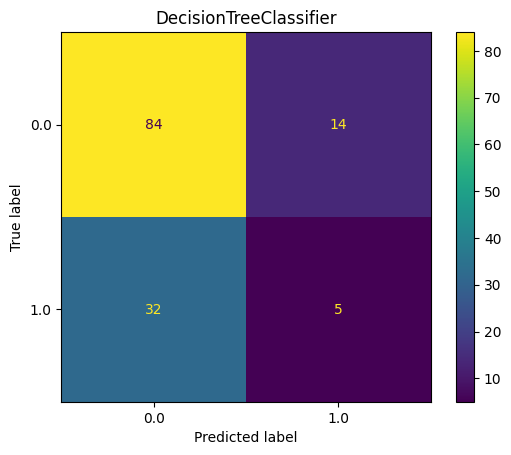

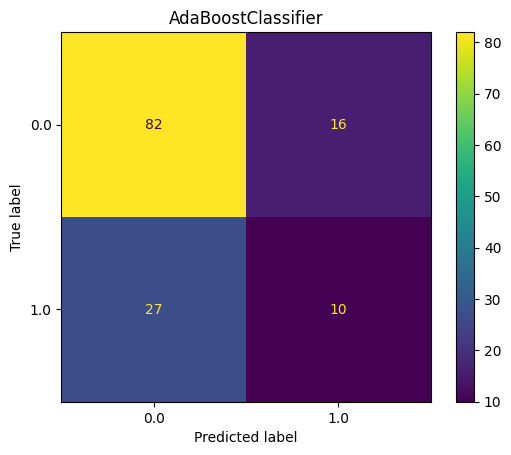

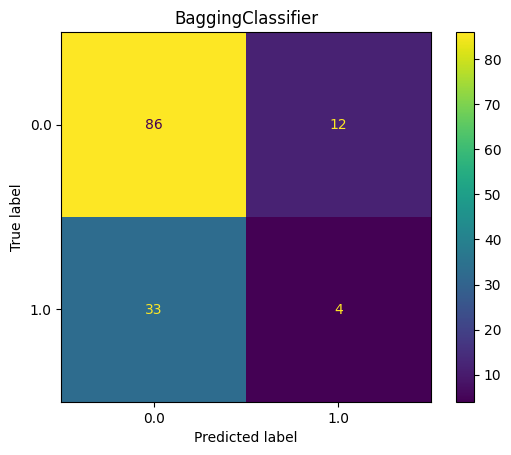

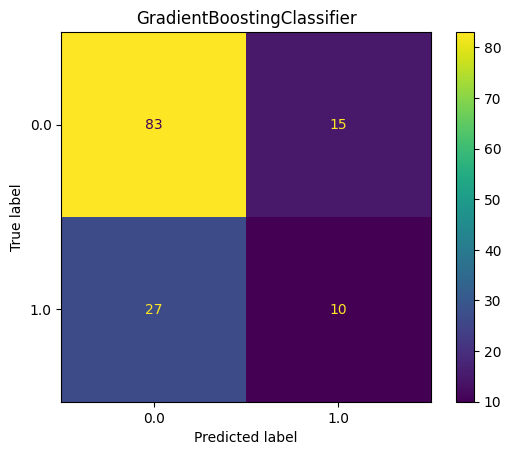

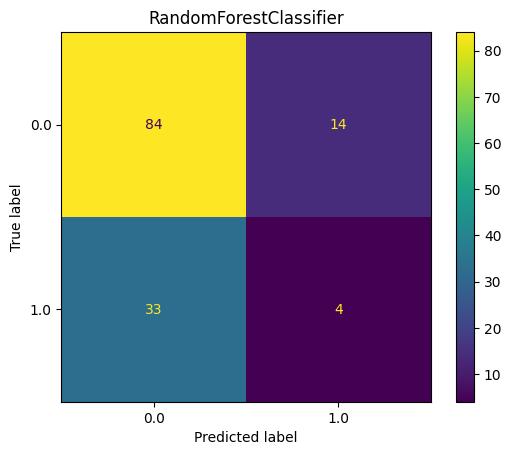

In [103]:
for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred[name]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

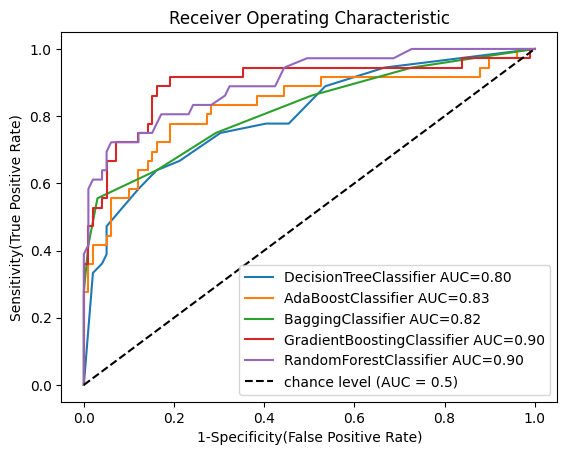

In [117]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}

for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    # data = {'fpr': fpr, 'trp': tpr, 'thresholds': thresholds}
    # df = pd.DataFrame(data)
    # df.head(100)
    roc_auc = auc(fpr, tpr)
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)

    # RocCurveDisplay.from_predictions(
    #     y_val,
    #     y_pred,
    #     name=f"My threshold",
    #     color="darkorange",
    # )
    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [81]:
data = {'fpr': fpr, 'trp': tpr, 'thresholds': thresholds}
df = pd.DataFrame(data)
df.head(len(fpr))

,fpr,trp,thresholds
0,0.000000,0.000000,2.000000
1,0.020202,0.333333,1.000000
2,0.040404,0.361111,0.714286
3,0.050505,0.388889,0.703704
4,0.050505,0.444444,0.448276
5,0.050505,0.472222,0.397260
6,0.121212,0.583333,0.289474
7,0.161616,0.638889,0.280000
8,0.212121,0.666667,0.205882
9,0.272727,0.722222,0.173913


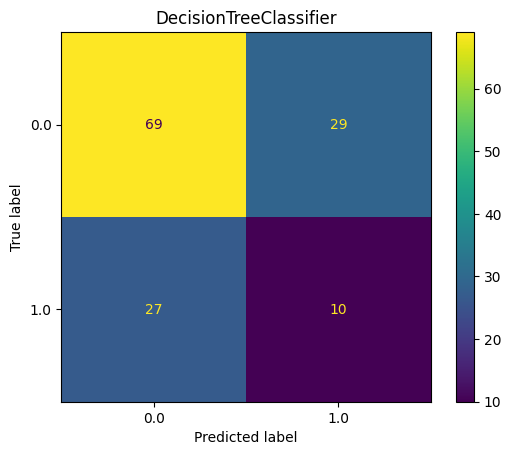

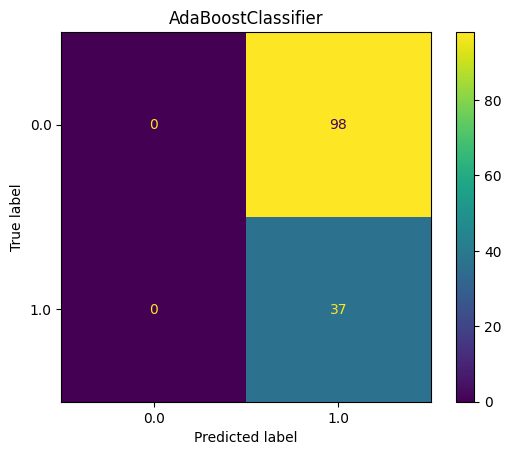

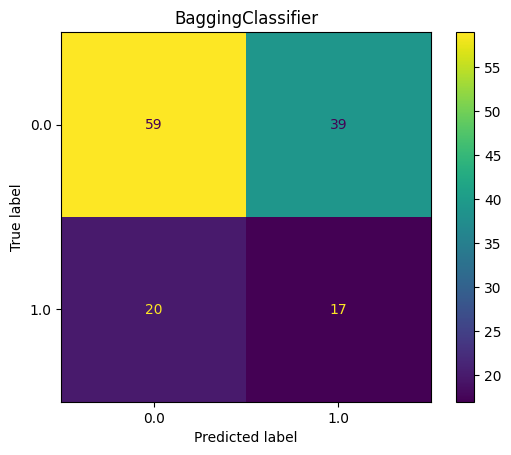

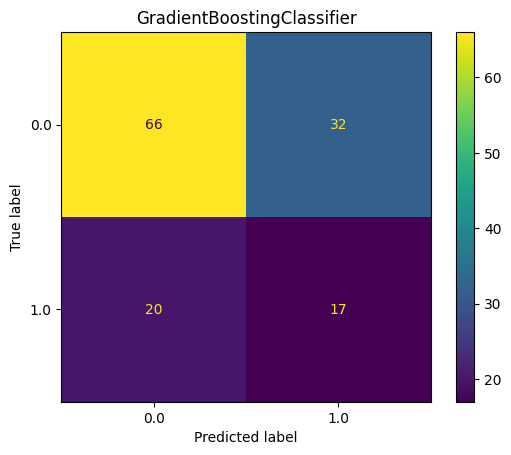

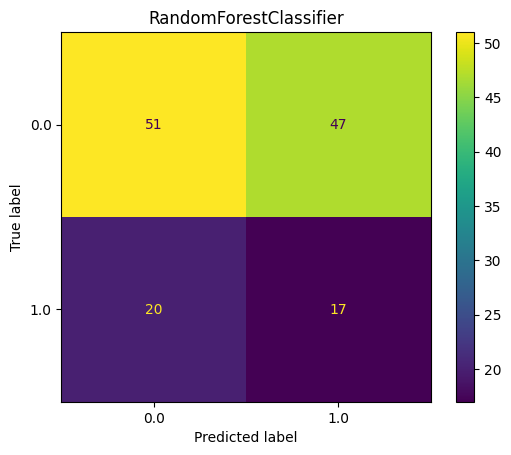

In [120]:
picked_th = 0.21
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = ys_pred_proba[name]
    cm = confusion_matrix(y_test, y_pred_proba>picked_th)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

In [122]:
data = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}

for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred_proba[name] > picked_th
    data['Name'].append(name)
    data['Accuracy'].append(accuracy_score(y_val, y_pred))
    data['F1 score'].append(f1_score(y_val, y_pred))
    data['Precision'].append(precision_score(y_val, y_pred))
    data['Recall'].append(recall_score(y_val, y_pred))

    # print(f"\n{name}")
    # print("Accuracy:", accuracy_score(y_val, y_pred))
    # print("F1 score:", f1_score(y_val, y_pred))
    # print("Precision:", precision_score(y_val, y_pred))
    # print("Recall:", recall_score(y_val, y_pred))

df = pd.DataFrame(data)
df.head(len(clfs_names))

,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.785185,0.613333,0.589744,0.638889
1,AdaBoostClassifier,0.266667,0.421053,0.266667,1.000000
2,BaggingClassifier,0.718519,0.586957,0.482143,0.750000
3,GradientBoostingClassifier,0.844444,0.752941,0.653061,0.888889
4,RandomForestClassifier,0.733333,0.640000,0.500000,0.888889
